Since the uprising of Artificial Intelligence, text classification has become one of the most staggering tasks to accomplish. In layman terms, We can say Artificial Intelligence is the field which tries to achieve human-like intelligent models to ease the jobs for all of us. We have an astounding proficiency in text classification but even many sophisticated NLP models are failed to achieve proficiency even close to it. So the question arises is that what we humans do differently? How do we classify text?

First of all, we understand words not each and every word but many of them and we can guess even unknown words just by the structure of a sentence. Then we understand the message that those series of words (sentence) conveys. Then from those series of sentences, we understand the meaning of a paragraph or an article. The similar approach is used in Hierarchical Attention model.

**To Learn Hierarchical Attention Network completely go [here](https://medium.com/@heetsankesara3/hierarchical-attention-networks-d220318cf87e)**

** Click [here](https://github.com/Hsankesara/DeepResearch/tree/master/Hierarchical_Attention_Network) to go to the code**


In [1]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer,  text_to_word_sequence
from keras.engine.topology import Layer
from keras import initializers as initializers, regularizers, constraints
from keras.callbacks import Callback, ModelCheckpoint
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding, Input, Dense, LSTM, GRU, Bidirectional, TimeDistributed, Dropout
from keras import backend as K
from keras import optimizers
from keras.models import Model
import nltk
import re
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_auc_score
from nltk import tokenize
import seaborn as sns

Using TensorFlow backend.


### Attention Layer

In [2]:
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)

class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

### Config

In [3]:
max_features=200000
max_senten_len=150
max_senten_num=4
embed_size=100
VALIDATION_SPLIT = 0.2

### Data

In [4]:
from sklearn.utils import shuffle

In [20]:
df = shuffle(pd.read_json(r'C:\\Users\\jana\\Desktop\\new project\\DeepResearch-master\\Hierarchical_Attention_Network\News_Category_Dataset\\News_Category_Dataset.json', lines=True)).reset_index()
print(pd.DataFrame(df['category'][:6].unique()))
#print(pd.DataFrame(df['authors'].unique()))

                0
0        POLITICS
1  HEALTHY LIVING
2         PARENTS
3   ENTERTAINMENT
4        BUSINESS


In [21]:
len(df.category.unique())

31

In [22]:
df.head()

,index,authors,category,date,headline,link,short_description
0,61312,Arthur Delaney and Zach Carter,POLITICS,2016-04-15,This Democrat Is Channeling FDR With A Plan To...,https://www.huffingtonpost.com/entry/zephyr-te...,Zephyr Teachout pitches more broadband as part...
1,35342,Mary Papenfuss,POLITICS,2017-02-04,Michigan GOP Official Calls For 'Another Kent ...,https://www.huffingtonpost.com/entry/michigan-...,"""One bullet stops a lot of thuggery,"" tweets D..."
2,77366,Kira Brekke,HEALTHY LIVING,2015-10-16,How Lisa Simpson Changed The Vegetarian Game,https://www.huffingtonpost.com/entry/lisa-simp...,"""The Simpsons"" character kissed meat goodbye t..."
3,11227,"Cindy Arboleda, Yahoo Lifestyle",PARENTS,2017-11-22,Mom Tracked Down The Same Stuffed Animal Her S...,https://www.huffingtonpost.com/entry/mom-track...,Nick Hollinger has held onto his stuffed anima...
4,2172,Jenna Amatulli,ENTERTAINMENT,2018-04-16,Fans Think Beyoncé Changed Her Nail Color Mid-...,https://www.huffingtonpost.com/entry/beyonce-c...,The singer did put on an incredible performanc...


In [24]:
df.category.unique()

array(['POLITICS', 'HEALTHY LIVING', 'PARENTS', 'ENTERTAINMENT',
       'BUSINESS', 'THE WORLDPOST', 'WEIRD NEWS', 'QUEER VOICES',
       'SPORTS', 'WOMEN', 'COMEDY', 'BLACK VOICES', 'FIFTY', 'GREEN',
       'STYLE', 'ARTS', 'IMPACT', 'WORLDPOST', 'RELIGION', 'CRIME',
       'ARTS & CULTURE', 'LATINO VOICES', 'WORLD NEWS', 'MEDIA', 'TASTE',
       'SCIENCE', 'TECH', 'TRAVEL', 'COLLEGE', 'GOOD NEWS', 'EDUCATION'],
      dtype=object)

In [26]:
df.category = df.category.map(lambda x: "WORLDPOST" if x == "THE WORLDPOST" else x)
print(df.category)

0               POLITICS
1               POLITICS
2         HEALTHY LIVING
3                PARENTS
4          ENTERTAINMENT
5               BUSINESS
6              WORLDPOST
7         HEALTHY LIVING
8              WORLDPOST
9               POLITICS
10        HEALTHY LIVING
11              POLITICS
12             WORLDPOST
13            WEIRD NEWS
14              BUSINESS
15              POLITICS
16          QUEER VOICES
17         ENTERTAINMENT
18                SPORTS
19              POLITICS
20                 WOMEN
21              POLITICS
22              POLITICS
23              POLITICS
24              POLITICS
25              POLITICS
26              POLITICS
27              POLITICS
28                COMEDY
29              POLITICS
               ...      
124959             GREEN
124960            TRAVEL
124961           COLLEGE
124962         EDUCATION
124963     ENTERTAINMENT
124964          POLITICS
124965     ENTERTAINMENT
124966             WOMEN
124967             CRIME


In [29]:
df['text'] = df['headline'] +'. ' +df['short_description']
print(df['text'].head())

0    This Democrat Is Channeling FDR With A Plan To...
1    Michigan GOP Official Calls For 'Another Kent ...
2    How Lisa Simpson Changed The Vegetarian Game. ...
3    Mom Tracked Down The Same Stuffed Animal Her S...
4    Fans Think Beyoncé Changed Her Nail Color Mid-...
Name: text, dtype: object


In [30]:
df.head()

,index,authors,category,date,headline,link,short_description,text
0,61312,Arthur Delaney and Zach Carter,POLITICS,2016-04-15,This Democrat Is Channeling FDR With A Plan To...,https://www.huffingtonpost.com/entry/zephyr-te...,Zephyr Teachout pitches more broadband as part...,This Democrat Is Channeling FDR With A Plan To...
1,35342,Mary Papenfuss,POLITICS,2017-02-04,Michigan GOP Official Calls For 'Another Kent ...,https://www.huffingtonpost.com/entry/michigan-...,"""One bullet stops a lot of thuggery,"" tweets D...",Michigan GOP Official Calls For 'Another Kent ...
2,77366,Kira Brekke,HEALTHY LIVING,2015-10-16,How Lisa Simpson Changed The Vegetarian Game,https://www.huffingtonpost.com/entry/lisa-simp...,"""The Simpsons"" character kissed meat goodbye t...",How Lisa Simpson Changed The Vegetarian Game. ...
3,11227,"Cindy Arboleda, Yahoo Lifestyle",PARENTS,2017-11-22,Mom Tracked Down The Same Stuffed Animal Her S...,https://www.huffingtonpost.com/entry/mom-track...,Nick Hollinger has held onto his stuffed anima...,Mom Tracked Down The Same Stuffed Animal Her S...
4,2172,Jenna Amatulli,ENTERTAINMENT,2018-04-16,Fans Think Beyoncé Changed Her Nail Color Mid-...,https://www.huffingtonpost.com/entry/beyonce-c...,The singer did put on an incredible performanc...,Fans Think Beyoncé Changed Her Nail Color Mid-...


In [31]:
df = df[['text', 'category']]

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124989 entries, 0 to 124988
Data columns (total 2 columns):
text        124989 non-null object
category    124989 non-null object
dtypes: object(2)
memory usage: 1.9+ MB


In [33]:
categories = df['category']
text = df['text']

In [34]:
cates = df.groupby('category')
print("total categories:", cates.ngroups)
print(cates.size())

total categories: 30
category
ARTS               1509
ARTS & CULTURE     1339
BLACK VOICES       3858
BUSINESS           4254
COLLEGE            1144
COMEDY             3971
CRIME              2893
EDUCATION          1004
ENTERTAINMENT     14257
FIFTY              1401
GOOD NEWS          1398
GREEN              2622
HEALTHY LIVING     6694
IMPACT             2602
LATINO VOICES      1129
MEDIA              2815
PARENTS            3955
POLITICS          32739
QUEER VOICES       4995
RELIGION           2556
SCIENCE            1381
SPORTS             4167
STYLE              2254
TASTE              2096
TECH               1231
TRAVEL             2145
WEIRD NEWS         2670
WOMEN              3490
WORLD NEWS         2177
WORLDPOST          6243
dtype: int64


In [35]:
import re
def clean_str(string):
    """
    Tokenization/string cleaning for dataset
    Every dataset is lower cased except
    """
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)    
    return string.strip().lower()

In [44]:
paras = []
labels = []
texts = []
print(df.text.head())
df.text.to_csv('narrow.txt')

0    This Democrat Is Channeling FDR With A Plan To...
1    Michigan GOP Official Calls For 'Another Kent ...
2    How Lisa Simpson Changed The Vegetarian Game. ...
3    Mom Tracked Down The Same Stuffed Animal Her S...
4    Fans Think Beyoncé Changed Her Nail Color Mid-...
Name: text, dtype: object


In [37]:
sent_lens = []
sent_nums = []
for idx in range(df.text.shape[0]):
    text = clean_str(df.text[idx])
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    sent_nums.append(len(sentences))
    for sent in sentences:
        sent_lens.append(len(sent))
    paras.append(sentences)

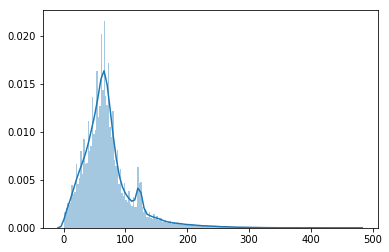

In [38]:
sns.distplot(sent_lens, bins=200)
plt.show()

c:\users\jana\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


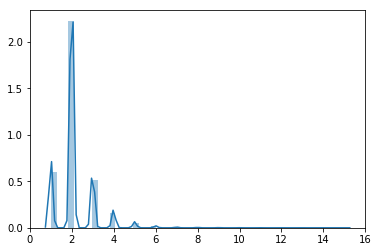

In [45]:
sns.distplot(sent_nums)
plt.show()

In [49]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(texts)

In [50]:
data = np.zeros((len(texts), max_senten_num, max_senten_len), dtype='int32')
for i, sentences in enumerate(paras):
    for j, sent in enumerate(sentences):
        if j< max_senten_num:
            wordTokens = text_to_word_sequence(sent)
            k=0
            for _, word in enumerate(wordTokens):
                try:
                    if k<max_senten_len and tokenizer.word_index[word]<max_features:
                        data[i,j,k] = tokenizer.word_index[word]
                        k=k+1
                except:
                    print(word)
                    pass

In [51]:
data.shape

(0, 4, 150)

In [52]:
word_index = tokenizer.word_index
print('Total %s unique tokens.' % len(word_index))

Total 0 unique tokens.


In [53]:
labels = pd.get_dummies(categories)

In [54]:
print('Shape of data tensor:', data.shape)
print('Shape of labels tensor:', labels.shape)

Shape of data tensor: (0, 4, 150)
Shape of labels tensor: (124989, 30)


In [55]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels.iloc[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]
print('Number of positive and negative reviews in traing and validation set')
print(y_train.columns.tolist())
print(y_train.sum(axis=0).tolist())
print(y_val.sum(axis=0).tolist())

Number of positive and negative reviews in traing and validation set
['ARTS', 'ARTS & CULTURE', 'BLACK VOICES', 'BUSINESS', 'COLLEGE', 'COMEDY', 'CRIME', 'EDUCATION', 'ENTERTAINMENT', 'FIFTY', 'GOOD NEWS', 'GREEN', 'HEALTHY LIVING', 'IMPACT', 'LATINO VOICES', 'MEDIA', 'PARENTS', 'POLITICS', 'QUEER VOICES', 'RELIGION', 'SCIENCE', 'SPORTS', 'STYLE', 'TASTE', 'TECH', 'TRAVEL', 'WEIRD NEWS', 'WOMEN', 'WORLD NEWS', 'WORLDPOST']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


### Model

In [56]:
REG_PARAM = 1e-13
l2_reg = regularizers.l2(REG_PARAM)

In [57]:
import os

In [60]:
GLOVE_DIR = "C:\\Users\\jana\\Desktop\\new project\\DeepResearch-master\\Hierarchical_Attention_Network\\glove.6B.100d.txt"
embeddings_index = {}
f = open(GLOVE_DIR,  encoding="utf8" )
for line in f:
    try:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    except:
        print(word)
        pass
f.close()
print('Total %s word vectors.' % len(embeddings_index))

Total 400000 word vectors.


In [75]:
embedding_matrix = np.zeros((len(word_index) + 1, embed_size))
absent_words = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        absent_words += 1
#print('Total absent words are', absent_words, 'which is', "%0.2f" % (absent_words * 100 / len(word_index)), '% of total words')
for word, i in word_index.items():
    #embedding_vector = embeddings_index.get(word)
    #print('Total absent words are', embedding_vector)
    print(word,'',i)

In [96]:
embedding_layer = Embedding(len(word_index) + 1,embed_size,weights=[embedding_matrix], input_length=max_senten_len, trainable=False)

In [97]:
word_input = Input(shape=(max_senten_len,), dtype='float32')
word_sequences = embedding_layer(word_input)
word_lstm = Bidirectional(LSTM(150, return_sequences=True, kernel_regularizer=l2_reg))(word_sequences)
word_dense = TimeDistributed(Dense(200, kernel_regularizer=l2_reg))(word_lstm)
word_att = AttentionWithContext()(word_dense)
wordEncoder = Model(word_input, word_att)

sent_input = Input(shape=(max_senten_num, max_senten_len), dtype='float32')
sent_encoder = TimeDistributed(wordEncoder)(sent_input)
sent_lstm = Bidirectional(LSTM(150, return_sequences=True, kernel_regularizer=l2_reg))(sent_encoder)
sent_dense = TimeDistributed(Dense(200, kernel_regularizer=l2_reg))(sent_lstm)
sent_att = Dropout(0.5)(AttentionWithContext()(sent_dense))
preds = Dense(30, activation='softmax')(sent_att)
model = Model(sent_input, preds)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])

In [109]:
checkpoint = ModelCheckpoint('best_model.hdf5', verbose=0, monitor='val_loss',save_best_only=True, mode='auto') 

In [110]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=25, verbose = 0, batch_size=84, callbacks=[checkpoint])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 4, 150)            0         
_________________________________________________________________
time_distributed_11 (TimeDis (None, 4, 200)            401900    
_________________________________________________________________
bidirectional_8 (Bidirection (None, 4, 300)            421200    
_________________________________________________________________
time_distributed_12 (TimeDis (None, 4, 200)            60200     
_________________________________________________________________
attention_with_context_8 (At (None, 200)               40400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 30)                6030      
Total para

## Plotting time

In [111]:
print(history.history.keys())

dict_keys([])


In [112]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

KeyError: 'acc'

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save('han.h5')